#**Hands-on Activity 8.1: Aggregating Data with Pandas**

##**8.1.1 Intended Learning Outcomes**
After this activity, the student should be able to:
- Demonstrate querying and merging of dataframes
- Perform advanced calculations on dataframes
- Aggregate dataframes with pandas and numpy
- Work with time series data




##**8.1.2 Resources**
- Computing Environment using Python 3.x
- Attached Datasets (under Instructional Materials)



##**8.1.3 Procedures**
The procedures can be found in the canvas module. Check the following under topics:
- 8.1 Weather Data Collection
- 8.2 Querying and Merging
- 8.3 Dataframe Operations
- 8.4 Aggregations
- 8.5 Time Series


####**Weather Data Collection**

In [ ]:
import requests
import datetime
import pandas as pd
import sqlite3
from IPython import display

class weather_data():
  def __init__(self):
    self.make_request()
    self.date()
    self.results = []
    self.response()
    self.dataframe()
    self.connection()

  def make_request(self, endpoint = 'data', payload = None):
    return requests.get(f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
                        headers={'token': 'uPbSRvXwGYFwftSwWzZNLZsxpPKvvaYN'},
                        params=payload)
  def date(self):
    self.current = datetime.date(2018, 1, 1)
    self.end = datetime.date(2019, 1, 1)

  def response(self):
    while self.current < self.end:
      display.clear_output(wait=True)
      display.display(f'Gathering data for {str(self.current)}')

      response = self.make_request(
          'data',
          {
              'datasetid' : 'GHCND',
              'locationid' : 'CITY:US360019',
              'startdate' : self.current,
              'enddate' : self.current,
              'units' : 'metric',
              'limit' : 1000
          }
      )

      if response.ok:
        self.results.extend(response.json()['results'])

      self.current += datetime.timedelta(days=1)

  def dataframe(self):
    self.df = pd.DataFrame(self.results)
    self.df.to_csv('/content/weather_data/nyc_weather_2018.csv', index = False)

  def connection(self):
    with sqlite3.connect('/content/weather_data/weather.db') as connection:
      self.df.to_sql('weather', connection, index = False, if_exists = 'replace')

    self.response = self.make_request('stations',{'datasetid':'GHCND',
                                        'locationid':'CITY:US360019',
                                        'limit':1000}
                            )

    self.stations = pd.DataFrame(self.response.json()['results'])[['id', 'name', 'latitude', 'longitude', 'elevation']]
    self.stations.to_csv('/content/weather_data/weather_stations.csv', index=False)

    with sqlite3.connect('/content/weather_data/weather.db') as connection:
      self.stations.to_sql('stations', connection, index=False, if_exists='replace')

weather = weather_data()

'Gathering data for 2018-12-31'

####**Querying and Merging**

In [ ]:
import pandas as pd
import sqlite3

class query_and_merge():
  def __init__(self):
    self.weather()
    self.query_weather()
    self.stationinfo()
    self.dirty_data()

    while True:
      try:
        x = input("\n0. Exit \n"\
                  "1. See the head of the weather dataframe \n"\
                  "2. See the head of the queried weather dataframe \n"\
                  "3. See the head of the station_info dataframe \n"\
                  "4. Describe unique values of station_info df \n"\
                  "5. Describe unique values of weather df \n"\
                  "6. Get info on station_info and weather dataframes \n"\
                  "7. Get sample on merged weather and station dfs \n"\
                  "8. Get sample on inner join \n"\
                  "9. Get tail on right join \n"\
                  "10. Get tail on left join \n"\
                  "11. Get sample on outer join \n"\
                  "12. Rows and columns after ij, lj, and rj \n"\
                  "13. See the head of the dirty data dataframe \n"\
                  "14. Get sample on valid stations \n"\
                  "15. Get sample on invalid stations \n"\
                  "16. See the head on the merged valid and invalid stations' dataframes \n"\
                  "17. See the head on the joined valid and invalid stations' dataframes \n"\
                  "18. See the intersection of the weather index \n"\
                  "19. See the difference of the weather index \n"\
                  "20. See the difference of the station info index \n"\
                  "21. ny_in_name == weather? \n"\
                  "22. All unique indexes of unioned weather and station_info dataframes \n"\
                  "> ")
        if x == "0":
          break
        elif x == "1":
          print(self.weather.head())
          continue
        elif x == "2":
          print(self.snow_data.head())
          continue
        elif x == "3":
          print(self.station_info.head())
          continue
        elif x == "4":
          print(self.station_info.id.describe())
          continue
        elif x == "5":
          print(self.weather.station.describe())
          continue
        elif x == "6":
          print(self.get_info('shape', self.station_info, self.weather))
          continue
        elif x == "7":
          print(self.weather.merge(self.station_info.rename(dict(id='station'), axis = 1), on = 'station').sample(5, random_state=0))
          continue
        elif x == "8":
          self.inner_join()
          print(self.inner_join.sample(5, random_state=0))
          continue
        elif x == "9":
          self.right_join()
          print(self.right_join.tail())
          continue
        elif x == "10":
          self.left_join()
          print(self.left_join.tail())
          continue
        elif x == "11":
          self.outer_join()
          print(self.outer_join.sample(4, random_state=0).append(self.outer_join[self.outer_join.station.isna()].head(2)))
          continue
        elif x == "12":
          print(self.get_info('shape', self.inner_join, self.left_join, self.right_join))
          continue
        elif x == "13":
          print(self.dirty_data.head())
          continue
        elif x == "14":
          self.valid()
          print(self.valid_station.sample(5, random_state = 0))
          continue
        elif x == "15":
          self.invalid()
          print(self.station_with_wesf.sample(5, random_state = 0))
          continue
        elif x == "16":
          print(self.valid_station.merge(self.station_with_wesf, left_index=True, right_index=True).query('WESF > 0').head())
          continue
        elif x == "17":
          print(self.valid_station.join(self.station_with_wesf, rsuffix='_?').query('WESF > 0').head())
          continue
        elif x == "18":
          self.set_index()
          print(self.weather.index.intersection(self.station_info.index))
          continue
        elif x == "19":
          print(self.weather.index.difference(self.station_info.index))
          continue
        elif x == "20":
          print(self.station_info.index.difference(self.weather.index))
          continue
        elif x == "21":
          self.symmetric_difference()
          print(self.ny_in_name.index.difference(self.weather.index).shape[0]\
          + self.weather.index.difference(self.ny_in_name.index).shape[0]\
          == self.weather.index.symmetric_difference(self.ny_in_name.index).shape[0])
          continue
        elif x == "22":
          print(self.weather.index.unique().union(self.station_info.index))
          continue

      except ValueError:
        print("Error Occured. Please try again")
        continue

  def weather(self):
    self.weather = pd.read_csv('/content/query_merge/nyc_weather_2018.csv')

  def query_weather(self):
    self.snow_data = self.weather.query('datatype == "SNOW" and value > 0')

  def stationinfo(self):
    self.station_info = pd.read_csv('/content/query_merge/weather_stations.csv')

  def inner_join(self):
    self.inner_join = self.weather.merge(self.station_info, left_on = 'station', right_on = 'id')

  def left_join(self):
    self.left_join = self.station_info.merge(self.weather, left_on = 'id', right_on = 'station', how = 'left')

  def right_join(self):
    self.right_join = self.weather.merge(self.station_info, left_on = 'station', right_on = 'id', how = 'right')

  def outer_join(self):
    self.outer_join = self.weather.merge(self.station_info[self.station_info.name.str.contains('NY')],
                                         left_on = 'station', right_on = 'id', how = 'outer', indicator = True)

  def dirty_data(self):
    self.dirty_data = pd.read_csv('/content/query_merge/dirty_data.csv', index_col='date').drop_duplicates().drop(columns='SNWD')

  def valid(self):
    self.valid_station = self.dirty_data.query('station != "?"').copy().drop(columns=['WESF', 'station'])

  def invalid(self):
    self.station_with_wesf = self.dirty_data.query('station == "?"').copy().drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])

  def set_index(self):
    self.weather.set_index('station', inplace=True)
    self.station_info.set_index('id', inplace=True)

  def symmetric_difference(self):
    self.ny_in_name = self.station_info[self.station_info.name.str.contains('NY')]

  def station_describe(self):
    self.station_info.id.describe()

  def get_info(self, attr, *dfs):
    return list(map(lambda x: getattr(x, attr), dfs))



QueryAndMerge = query_and_merge()


0. Exit 
1. See the head of the weather dataframe 
2. See the head of the queried weather dataframe 
3. See the head of the station_info dataframe 
4. Describe unique values of station_info df 
5. Describe unique values of weather df 
6. Get info on station_info and weather dataframes 
7. Get sample on merged weather and station dfs 
8. Get sample on inner join 
9. Get tail on right join 
10. Get tail on left join 
11. Get sample on outer join 
12. Rows and columns after ij, lj, and rj 
13. See the head of the dirty data dataframe 
14. Get sample on valid stations 
15. Get sample on invalid stations 
16. See the head on the merged valid and invalid stations' dataframes 
17. See the head on the joined valid and invalid stations' dataframes 
18. See the intersection of the weather index 
19. See the difference of the weather index 
20. See the difference of the station info index 
21. ny_in_name == weather? 
22. All unique indexes of unioned weather and station_info dataframes 
> 1
  at

<ipython-input-15-ddc07fe64e87>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  print(self.outer_join.sample(4, random_state=0).append(self.outer_join[self.outer_join.station.isna()].head(2)))


      attributes datatype                 date            station  value  \
17259       ,,N,     PRCP  2018-05-15T00:00:00  GHCND:US1NJPS0022    0.3   
76178       ,,N,     PRCP  2018-05-19T00:00:00  GHCND:US1NJPS0015    8.1   
73410       ,,N,     MDPR  2018-08-05T00:00:00  GHCND:US1NYNS0018   12.2   
74822       ,,N,     SNOW  2018-04-02T00:00:00  GHCND:US1NJMS0016  178.0   
80256        NaN      NaN                  NaN                NaN    NaN   
80257        NaN      NaN                  NaN                NaN    NaN   

                      id                                  name  latitude  \
17259                NaN                                   NaN       NaN   
76178                NaN                                   NaN       NaN   
73410  GHCND:US1NYNS0018             HICKSVILLE 1.3 ENE, NY US   40.7687   
74822                NaN                                   NaN       NaN   
80256  GHCND:US1NJMS0036  PARSIPPANY TROY HILLS TWP 2.1, NJ US   40.8656   
80257  GHCN

####**Dataframe Operations**

#####Arithmetic and Statistics

In [ ]:
import numpy as np
import pandas as pd
weather = pd.read_csv('/content/Arithmetic_and_Stat/nyc_weather_2018.csv', parse_dates=['date'])
fb = pd.read_csv('/content/Arithmetic_and_Stat/fb_2018.csv', index_col='date', parse_dates=True)

x = fb.assign(abs_z_score_volume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs())
y = fb.assign(volume_pct_change=fb.volume.pct_change(),
              pct_change_rank=lambda x: x.volume_pct_change.abs().rank(ascending=False))
print("abs_z_score_volume > 3")
print(x.query('abs_z_score_volume > 3'))
print("\n\n\npct_change_rank")
print(y.nsmallest(5, 'pct_change_rank'))
print("\n\n\n2018-01-11':'2018-01-12")
print(fb['2018-01-11':'2018-01-12'])
print("\n\n\nThroughout 2018, Facebook's stock price never had a low above $215:")
print((fb > 215).any())
print("\n\n\nFacebook's OHLC (open, high, low, and close) prices all had at least one day they were at $215 or less:")
print((fb > 215).all())

abs_z_score_volume > 3
              open    high     low   close     volume  abs_z_score_volume
date                                                                     
2018-03-19  177.01  177.17  170.06  172.56   88140060            3.145078
2018-03-20  167.47  170.20  161.95  168.15  129851768            5.315169
2018-03-21  164.80  173.40  163.30  169.39  106598834            4.105413
2018-03-26  160.82  161.10  149.02  160.06  126116634            5.120845
2018-07-26  174.89  180.13  173.75  176.26  169803668            7.393705



pct_change_rank
              open    high     low   close     volume  volume_pct_change  \
date                                                                       
2018-01-12  178.06  181.48  177.40  179.37   77551299           7.087876   
2018-03-19  177.01  177.17  170.06  172.56   88140060           2.611789   
2018-07-26  174.89  180.13  173.75  176.26  169803668           1.628841   
2018-09-21  166.64  167.25  162.81  162.93   45994800       

#####Binning and Thresholds

In [ ]:
import matplotlib.pyplot as plt

volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
print(volume_binned.value_counts())
print("\n\n\nJuly 25th Facebook announced disappointing user growth and the stock tanked in the after hours:")
print(fb['2018-07-25':'2018-07-26'])
print("\n\n\nCambridge Analytica scandal broke on Saturday March 17th, so we look to the Monday for the numbers:")
print(fb['2018-03-16':'2018-03-20'])

low     240
med       8
high      3
Name: volume, dtype: int64



July 25th Facebook announced disappointing user growth and the stock tanked in the after hours:
               open    high     low   close     volume
date                                                  
2018-07-25  215.715  218.62  214.27  217.50   64592585
2018-07-26  174.890  180.13  173.75  176.26  169803668



Cambridge Analytica scandal broke on Saturday March 17th, so we look to the Monday for the numbers:
              open    high     low   close     volume
date                                                 
2018-03-16  184.49  185.33  183.41  185.09   24403438
2018-03-19  177.01  177.17  170.06  172.56   88140060
2018-03-20  167.47  170.20  161.95  168.15  129851768


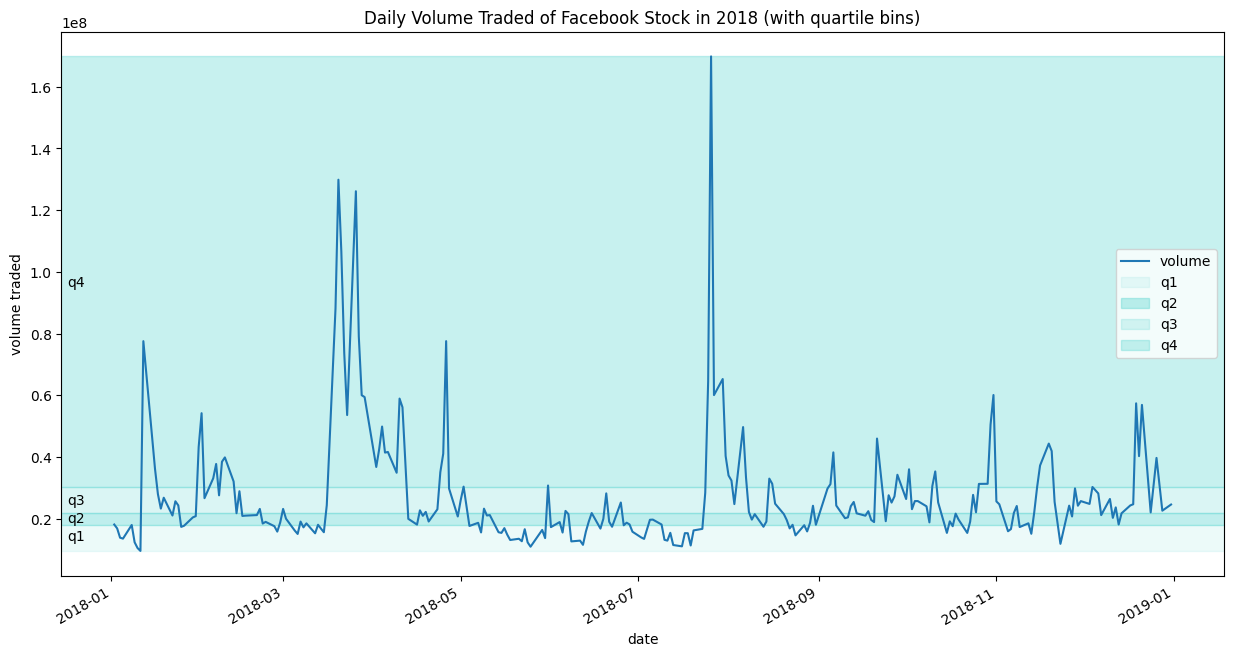

In [ ]:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')

for bin_name, alpha, bounds in zip(
    ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
    ):
  plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
  plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

In [ ]:
central_park_weather = weather.query(
    'station == "GHCND:USW00094728"'
    ).pivot(index='date', columns='datatype', values='value')
central_park_weather.SNOW.clip(0, 1).value_counts()

0.0    354
1.0     11
Name: SNOW, dtype: int64

#####Applying Functions

In [ ]:
import numpy as np
oct_weather_z_scores = central_park_weather.loc['2018-10', ['TMIN', 'TMAX', 'PRCP']].apply(lambda x: x.sub(x.mean()).div(x.std()))
print("October 27th rained much more than the rest of the days:")
print(oct_weather_z_scores.query('PRCP > 3'))
print("\n\n\nIndeed, this day was much higher than the rest:")
print(central_park_weather.loc['2018-10', 'PRCP'].describe())
print("\n\n\n")
fb.apply(lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)).astype('int64').equals(fb.applymap(lambda x: len(str(np.ceil(x))))        )

October 27th rained much more than the rest of the days:
datatype        TMIN      TMAX      PRCP
date                                    
2018-10-27 -0.751019 -1.201045  3.936167



Indeed, this day was much higher than the rest:
count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64






True

<ipython-input-17-b1f8f4319006>:22: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, v in test.iteritems():


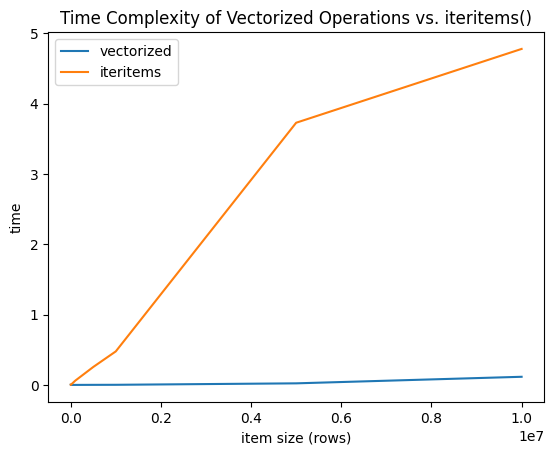

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(0)

vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
  test = pd.Series(np.random.uniform(size=size))

  start = time.time()
  x = test + 10
  end = time.time()
  vectorized_results[size] = end - start

  start = time.time()
  x = []
  for i, v in test.iteritems():
    x.append(v + 10)
  x = pd.Series(x)
  end = time.time()
  iteritems_results[size] = end - start

pd.DataFrame(
    [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
    ).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')

plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()

#####Window Calculations

In [ ]:
rolling = central_park_weather['2018-10'].assign(rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum())[['PRCP', 'rolling_PRCP']]
print("Rolling Calculation of Central Park Weather for October 2018")
print(rolling.head(7).T)
print("\n\n\nPerforming Several Operations on the data in the '2018-10' column")
print(central_park_weather['2018-10'].rolling('3D').mean().head(7).iloc[:,:6])

rolling_func_per_column = central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}).join(central_park_weather[
        ['TMAX', 'TMIN', 'AWND', 'PRCP']],lsuffix='_rolling')
print("\n\n\nDifferent Aggregation Functions per Column")
print(rolling_func_per_column.sort_index(axis=1))

isequal = central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum())
print("\n\n\nIs the expanding calculation of the precipitation in central park equal to the cumulative sum of it?")
print(isequal)

expanding_agg_per_column = central_park_weather['2018-10-01':'2018-10-07'].expanding().agg({'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}).join(
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],lsuffix='_expanding')
print("\n\n\nExpanding Aggregations per column")
print(expanding_agg_per_column.sort_index(axis=1))

moving_average = fb.assign(close_ewma=lambda x: x.close.ewm(span=5).mean())
print("\n\n\nExponentially Weighted Moving Average")
print(moving_average.tail(10)[['close','close_ewma']])

Rolling Calculation of Central Park Weather for October 2018
date          2018-10-01  2018-10-02  2018-10-03  2018-10-04  2018-10-05  \
datatype                                                                   
PRCP                 0.0        17.5         0.0         1.0         0.0   
rolling_PRCP         0.0        17.5        17.5        18.5         1.0   

date          2018-10-06  2018-10-07  
datatype                              
PRCP                 0.0         0.0  
rolling_PRCP         1.0         0.0  



Performing Several Operations on the data in the '2018-10' column
datatype        AWND      PRCP  SNOW  SNWD       TMAX       TMIN
date                                                            
2018-10-01  0.900000  0.000000   0.0   0.0  24.400000  17.200000
2018-10-02  0.900000  8.750000   0.0   0.0  24.700000  17.750000
2018-10-03  0.966667  5.833333   0.0   0.0  24.233333  17.566667
2018-10-04  0.800000  6.166667   0.0   0.0  24.233333  17.200000
2018-10-05  1.03333

<ipython-input-25-cc70780dd680>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  rolling = central_park_weather['2018-10'].assign(rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum())[['PRCP', 'rolling_PRCP']]
<ipython-input-25-cc70780dd680>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(central_park_weather['2018-10'].rolling('3D').mean().head(7).iloc[:,:6])


#####Pipes

In [ ]:
def get_info(df):
  return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())

getinfo = fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
== get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

print("Is the result of using the custom 'get_info' function the same as the get_info function using the pipe method?")
print(getinfo)

pipe_rolling = fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())
print("\n\n\nIs the result of directly using the rolling method for the calculation of the mean the same as using pipe?")
print(pipe_rolling)

def window_calc(df, func, agg_dict, *args, **kwargs):
  return df.pipe(func, *args, **kwargs).agg(agg_dict)

print("\n\n\nExpanding Median of FB using Pipe and Rolling Method (without args and kwargs)")
print(window_calc(fb, pd.DataFrame.expanding, np.median).head())

print("\n\n\nExponentially Weighted Moving Average (with kwargs)")
print(window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head())

print("\n\n\nWindow Calculation using args for the indow size")
print(window_calc(central_park_weather['2018-10'], pd.DataFrame.rolling,
 {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},'3D').head())

Is the result of using the custom 'get_info' function the same as the get_info function using the pipe method?
True



Is the result of directly using the rolling method for the calculation of the mean the same as using pipe?
True



Expanding Median of FB using Pipe and Rolling Method (without args and kwargs)
              open     high       low    close      volume
date                                                      
2018-01-02  177.68  181.580  177.5500  181.420  18151903.0
2018-01-03  179.78  183.180  179.4400  183.045  17519233.0
2018-01-04  181.88  184.780  181.3300  184.330  16886563.0
2018-01-05  183.39  185.495  182.7148  184.500  15383729.5
2018-01-08  184.90  186.210  184.0996  184.670  16886563.0



Exponentially Weighted Moving Average (with kwargs)
                  open        high         low       close        volume
date                                                                    
2018-01-02  177.680000  181.580000  177.550000  181.420000  1.815190e+07


<ipython-input-30-3fcf3e16cf1b>:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  getinfo = fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
<ipython-input-30-3fcf3e16cf1b>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  == get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))
<ipython-input-30-3fcf3e16cf1b>:24: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(window_calc(central_park_weather['2018-10'], pd.DataFrame.rolling,


####**Aggregations**

#####Summarizing DataFrames

In [ ]:
import numpy as np
import pandas as pd
weather = pd.read_csv('/content/Aggregations/weather_by_station.csv', index_col='date', parse_dates=True)
fb = pd.read_csv('/content/Aggregations/fb_2018.csv', index_col='date', parse_dates=True).assign(
    trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
    )
pd.set_option('display.float_format', lambda x: '%.2f' % x) #All numerical outputs will be shown in 2 rounded decimal places whilst not affecting the original value
print("Aggregate into a Single Series")
agg = fb.agg({
    'open': np.mean,
    'high': np.max,
    'low': np.min,
    'close': np.mean,
    'volume': np.sum
    })
print(agg)
print("\n\n\nSnowfall and Precipitation Recorded in Central Park in 2018")
print(weather.query('station == "GHCND:USW00094728"').pivot(
    columns='datatype', values='value')[['SNOW', 'PRCP']].agg('sum'))
print("\n\n\nAggregate into a Data Frame")
agg_df = fb.agg({
    'open': 'mean',
    'high': ['min', 'max'],
    'low': ['min', 'max'],
    'close': 'mean'
    })
print(agg_df)


Aggregate into a Single Series
open            171.45
high            218.62
low             123.02
close           171.51
volume   6949682394.00
dtype: float64



Snowfall and Precipitation Recorded in Central Park in 2018
datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64



Aggregate into a Data Frame
       open   high    low  close
mean 171.45    NaN    NaN 171.51
min     NaN 129.74 123.02    NaN
max     NaN 218.62 214.27    NaN


#####Using groupby()

In [ ]:
groupby = fb.groupby('trading_volume').mean()
agg_groupby = fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])

print("Mean based on the trading volume")
print(groupby)
print("\n\n\nAggregated Values of each row of the trading volume")
print(agg_groupby)

fb_agg = fb.groupby('trading_volume').agg({
    'open': 'mean',
    'high': ['min', 'max'],
    'low': ['min', 'max'],
    'close': 'mean'
    })

print("\n\n\nGrouped Aggregation of each row of the trading volume")
print(fb_agg)

print("\n\n\nHierarchical names of the columns in the dataframe")
print(fb_agg.columns)

print("\n\n\nJoining the hierarchical names into one")
fb_agg.columns = ['_'.join(col_agg) for col_agg in fb_agg.columns]
print(fb_agg.head())

print("\n\n\nAverage Precipitation Per Day during October 2018")
print(weather['2018-10'].query('datatype == "PRCP"').groupby(
    pd.Grouper(freq='D')
    ).mean().head())

print("\n\n\nTotal Quarterly Precipitation Per Station")
print(weather.query('datatype == "PRCP"').groupby(
    ['station_name', pd.Grouper(freq='Q')]
    ).sum().unstack().sample(5, random_state=1))

print("\n\n\nTotal snowfall per New York Station (in millimeters)")
print(weather.groupby('station').filter(lambda x: 'NY' in x.name).query(
    'datatype == "SNOW"').groupby('station_name').sum().squeeze())

print("\n\n\n5 months with the most precipitation")
print(weather.query('datatype == "PRCP"').groupby(
    pd.Grouper(freq='D')
    ).mean().groupby(pd.Grouper(freq='M')).sum().value.nlargest())

print("\n\n\nThe five largest percentage of daily precipitation relative to the total precipitation in that month")
print(weather\
.query('datatype == "PRCP"')\
.rename(dict(value='prcp'), axis=1)\
.groupby(pd.Grouper(freq='D')).mean()\
.assign(
    total_prcp_in_month=lambda x: x.groupby(
        pd.Grouper(freq='M')
        ).transform(np.sum),
    pct_monthly_prcp=lambda x: x.prcp.div(
        x.total_prcp_in_month
        )
    ).nlargest(5, 'pct_monthly_prcp'))

print("\n\n\nStandardized Dataframe using transform")
print(fb[['open', 'high', 'low', 'close']].transform(
    lambda x: (x - x.mean()).div(x.std())
    ).head())

Mean based on the trading volume
                 open   high    low  close       volume
trading_volume                                         
low            171.36 173.46 169.31 171.43  24547207.71
med            175.82 179.42 172.11 175.14  79072559.12
high           167.73 170.48 161.57 168.16 141924023.33



Aggregated Values of each row of the trading volume
                  min    max   mean
trading_volume                     
low            124.06 214.67 171.43
med            152.22 217.50 175.14
high           160.06 176.26 168.16



Grouped Aggregation of each row of the trading volume
                 open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.36 129.74 216.20 123.02 212.60 171.43
med            175.82 162.85 218.62 150.75 214.27 175.14
high           167.73 161.10 180.13 149.02 173.75 168.16



Hierarchical names of the columns in the dataframe

<ipython-input-41-5324be2d555e>:27: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(weather['2018-10'].query('datatype == "PRCP"').groupby(
<ipython-input-41-5324be2d555e>:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().head())
<ipython-input-41-5324be2d555e>:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).sum().unstack().sample(5, random_state=1))
<ipython-input-41-5324be2d555e>:38: FutureWarning: The default value of nume

#####Pivot Tables and Crosstabs

In [ ]:
print("Pivot around trading volume as the column")
print(fb.pivot_table(columns='trading_volume'))
print("\n\n\nPivot around trading volume as the index")
print(fb.pivot_table(index='trading_volume'))

print("\n\n\nWeather data in the wide format")
print(weather.reset_index().pivot_table(
    index=['date', 'station', 'station_name'],
    columns='datatype',
    values='value',
    aggfunc='median'
    ).reset_index().tail())

from google.colab import drive
drive.mount('/content/drive')

print("\n\n\nFrequency Table for Trading Volume per Month")
print(pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month']
    ))

print("\n\n\nPercentage of the value in each row relative to the total value per month")
print(pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'],
    normalize='columns'
    ))

print("\n\n\nAverage trading volume per month")
print(pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'],
    values=fb.close,
    aggfunc=np.mean
    ))

print("\n\n\nNumber of times each station recorded snowfall per month")
snow_data = weather.query('datatype == "SNOW"')
print(pd.crosstab(
    index=snow_data.station_name,
    columns=snow_data.index.month,
    colnames=['month'],
    values=snow_data.value,
    aggfunc=lambda x: (x > 0).sum(),
    margins=True,
    margins_name='total observations of snow'
    ))

Pivot around trading volume as the column
trading_volume         low         med         high
close               171.43      175.14       168.16
high                173.46      179.42       170.48
low                 169.31      172.11       161.57
open                171.36      175.82       167.73
volume         24547207.71 79072559.12 141924023.33



Pivot around trading volume as the index
                close   high    low   open       volume
trading_volume                                         
low            171.43 173.46 169.31 171.36  24547207.71
med            175.14 179.42 172.11 175.82  79072559.12
high           168.16 170.48 161.57 167.73 141924023.33



Weather data in the wide format
datatype       date            station                         station_name  \
28740    2018-12-31  GHCND:USW00054787  FARMINGDALE REPUBLIC AIRPORT, NY US   
28741    2018-12-31  GHCND:USW00094728          NY CITY CENTRAL PARK, NY US   
28742    2018-12-31  GHCND:USW00094741            

####**Time Series**

#####Time-Based Selection and Filtering

In [ ]:
import numpy as np
import pandas as pd

fb = pd.read_csv('/content/Time_Series/fb_2018.csv', index_col='date', parse_dates=True).assign(
    trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
    )
print("As the index of the dataframe is the date, it does not include rows with dates under holidays or weekends")
print("Weekends (Called October 11-15):\n",fb['2018-10-11':'2018-10-15'])
print("\n\n\nHolidays (Called January 1-7):\n",fb.first('1W')) #first takes from the beginning, last takes from the end
stock_data_per_minute = pd.read_csv('/content/Time_Series/fb_week_of_may_20_per_minute.csv',
                                    index_col='date', parse_dates=True,
                                    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H-%M'))
print("\n\n\nStock Data per Minute:\n", stock_data_per_minute.head())
print("\n\n\nStock Data per Day:\n", stock_data_per_minute.groupby(pd.Grouper(freq='1D')).agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
    }))
print("\n\n\nData at a specific time per day (i.e. 9:30, 15:59-16:00, etc.):\n",
      "At a time\n", stock_data_per_minute.at_time('9:30'),
      "\n\n\n",
      "Between times\n",stock_data_per_minute.between_time('15:59', '16:00'))

shares_traded_in_first_30_min = stock_data_per_minute\
  .between_time('9:30', '10:00')\
  .groupby(pd.Grouper(freq='1D'))\
  .filter(lambda x: (x.volume > 0).all())\
  .volume.mean()

shares_traded_in_last_30_min = stock_data_per_minute\
  .between_time('15:30', '16:00')\
  .groupby(pd.Grouper(freq='1D'))\
  .filter(lambda x: (x.volume > 0).all())\
  .volume.mean()

print("\n\n\nDifference between the average shares traded in the first 30 minutes to the last 30 minutes everyday: \n",
      shares_traded_in_first_30_min - shares_traded_in_last_30_min,
      "-- A positive number means that more shares are traded in the first 30 minutes, while a negative number is the opposite")

print("\n\n\nUsing Normalize to remove all specific time information:\n",
      pd.DataFrame(dict(before=stock_data_per_minute.index,
                        after=stock_data_per_minute.index.normalize())).head())

As the index of the dataframe is the date, it does not include rows with dates under holidays or weekends
Weekends (Called October 11-15):
              open   high    low  close    volume trading_volume
date                                                           
2018-10-11 150.13 154.81 149.16 153.35  35338901            low
2018-10-12 156.73 156.89 151.30 153.74  25293492            low
2018-10-15 153.32 155.57 152.55 153.52  15433521            low



Holidays (Called January 1-7):
              open   high    low  close    volume trading_volume
date                                                           
2018-01-02 177.68 181.58 177.55 181.42  18151903            low
2018-01-03 181.88 184.78 181.33 184.67  16886563            low
2018-01-04 184.90 186.21 184.10 184.33  13880896            low
2018-01-05 185.59 186.90 184.93 186.85  13574535            low



Stock Data per Minute:
                       open   high    low  close    volume
date                                

#####Shifting for Lagged Data

In [ ]:
print("Using shift() to determine the previous day's closing price and change in price:\n",
      fb.assign(prior_close=lambda x: x.close.shift(),
          after_hours_change_in_price=lambda x: x.open - x.prior_close,
          abs_change=lambda x: x.after_hours_change_in_price.abs()).nlargest(5, 'abs_change'))

print("\n\n\nAligning the starting time to the Market Hours:\n",
      pd.date_range('2018-01-01', freq='D', periods=5) + pd.Timedelta('9 hours 30 minutes'))

print("\n\n\nFinding the valid/non-null/non-missing data in the month of September\n",
      "First:", fb['2018-09'].first_valid_index(),
      "\n Last:", fb['2018-09'].last_valid_index())

print("\n\n\nIs the market open on Feb. 30?\n",
     (fb.index == '2018-09-30').any(),
      "\n\n\nData on the last time the market was open:",
      fb.asof('2018-09-30'))

Using shift() to determine the previous day's closing price and change in price:
              open   high    low  close     volume trading_volume  prior_close  \
date                                                                            
2018-07-26 174.89 180.13 173.75 176.26  169803668           high       217.50   
2018-04-26 173.22 176.27 170.80 174.16   77556934            med       159.69   
2018-01-12 178.06 181.48 177.40 179.37   77551299            med       187.77   
2018-10-31 155.00 156.40 148.96 151.79   60101251            low       146.22   
2018-03-19 177.01 177.17 170.06 172.56   88140060            med       185.09   

            after_hours_change_in_price  abs_change  
date                                                 
2018-07-26                       -42.61       42.61  
2018-04-26                        13.53       13.53  
2018-01-12                        -9.71        9.71  
2018-10-31                         8.78        8.78  
2018-03-19                

<ipython-input-67-581a5bc14eac>:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  "First:", fb['2018-09'].first_valid_index(),
<ipython-input-67-581a5bc14eac>:11: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  "\n Last:", fb['2018-09'].last_valid_index())


#####Differenced Data

In [ ]:
print("Is the result of subtracting each element from its",
      "\npreceding element using the shift method equal to the\n",
      "\bresult obtained by using the diff method?\n",
 (fb.drop(columns='trading_volume') - fb.drop(columns='trading_volume').shift()
    ).equals(fb.drop(columns='trading_volume').diff()))

print("\n\n\nDaily Difference of Facebook stock\n",
      fb.drop(columns='trading_volume').diff().head(),
      "\n\nDifference between current value and the values three positions behind it\n",
      fb.drop(columns='trading_volume').diff(-3).head())


Is the result of subtracting each element from its 
preceding element using the shift method equal to the
 result obtained by using the diff method?
 True



Daily Difference of Facebook stock
             open  high  low  close      volume
date                                          
2018-01-02   NaN   NaN  NaN    NaN         NaN
2018-01-03  4.20  3.20 3.78   3.25 -1265340.00
2018-01-04  3.02  1.43 2.77  -0.34 -3005667.00
2018-01-05  0.69  0.69 0.83   2.52  -306361.00
2018-01-08  1.61  2.00 1.40   1.43  4420191.00 

Difference between current value and the values three positions behind it
             open  high   low  close      volume
date                                           
2018-01-02 -7.91 -5.32 -7.38  -5.43  4577368.00
2018-01-03 -5.32 -4.12 -5.00  -3.61 -1108163.00
2018-01-04 -3.80 -2.59 -3.00  -3.54  1487839.00
2018-01-05 -1.35 -0.99 -0.70  -0.99  3044641.00
2018-01-08 -1.20  0.50 -1.05   0.51  8406139.00


#####Resampling

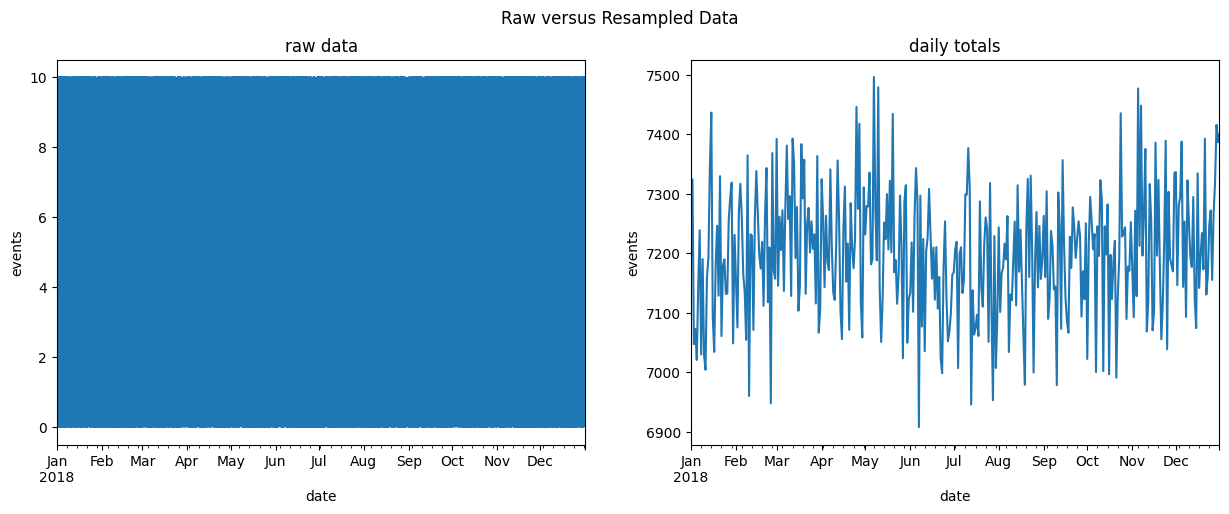

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(0)
index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)
raw = pd.DataFrame(
    np.random.uniform(0, 10, size=index.shape[0]), index=index
    )

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
raw.plot(legend=False, ax=axes[0], title='raw data')
raw.resample('1D').sum().plot(legend=False, ax=axes[1], title='daily totals')
for ax in axes:
  ax.set_xlabel('date')
  ax.set_ylabel('events')

plt.suptitle('Raw versus Resampled Data')
plt.show()

In [ ]:
print("Resampling the stock data per minute to get the daily frequency\n",
      "Head: \n", stock_data_per_minute.head(),
      "\n\nResampled: \n", stock_data_per_minute.resample('1D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
    }))
print("\n\n\nDownsampling to quarterly data:\n",
      fb.resample('Q').mean())
print("\n\n\nQuarterly change from start to end:\n",
      fb.drop(columns='trading_volume').resample('Q').apply(
    lambda x: x.last('1D').values - x.first('1D').values
    ))

melted_stock_data = pd.read_csv('/content/Time_Series/melted_stock_data.csv', index_col='date', parse_dates=True)
print("\n\n\nResampling Melted Stock prices:\n",
      melted_stock_data.resample('1D').ohlc()['price'],
      "\n\nPer 6 hours\n",
      fb.resample('6H').asfreq().head(),
      "\n\nHandle NaN Values using:\n",
      "\nPad(): \n", fb.resample('6H').pad().head(),
      "\n\nfillna(): \n", fb.resample('6H').fillna('nearest').head(),
      "\n\nasfreq() and assign(): \n",
      fb.resample('6H').asfreq().assign(
          volume=lambda x: x.volume.fillna(0),
          close=lambda x: x.close.fillna(method='ffill'),
          open=lambda x: np.where(x.open.isnull(), x.close, x.open),
          high=lambda x: np.where(x.high.isnull(), x.close, x.high),
          low=lambda x: np.where(x.low.isnull(), x.close, x.low)).head())

Resampling the stock data per minute to get the daily frequency
 Head: 
                       open   high    low  close    volume
date                                                     
2019-05-20 09:30:00 181.62 181.62 181.62 181.62 159049.00
2019-05-20 09:31:00 182.61 182.61 182.61 182.61 468017.00
2019-05-20 09:32:00 182.75 182.75 182.75 182.75  97258.00
2019-05-20 09:33:00 182.95 182.95 182.95 182.95  43961.00
2019-05-20 09:34:00 183.06 183.06 183.06 183.06  79562.00 

Resampled: 
              open   high    low  close      volume
date                                              
2019-05-20 181.62 184.18 181.62 182.72 10044838.00
2019-05-21 184.53 185.58 183.97 184.82  7198405.00
2019-05-22 184.81 186.56 184.01 185.32  8412433.00
2019-05-23 182.50 183.73 179.76 180.87 12479171.00
2019-05-24 182.33 183.52 181.04 181.06  7686030.00



Downsampling to quarterly data:
              open   high    low  close      volume
date                                              
2018-03-31 

<ipython-input-82-70ebf7a11853>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fb.resample('Q').mean())
<ipython-input-82-70ebf7a11853>:23: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  "\nPad(): \n", fb.resample('6H').pad().head(),


#####Merging

In [ ]:
import sqlite3

with sqlite3.connect('/content/Time_Series/stocks.db') as connection:
  fb_prices = pd.read_sql(
      'SELECT * FROM fb_prices', connection,
      index_col='date', parse_dates=['date']
      )
  aapl_prices = pd.read_sql(
      'SELECT * FROM aapl_prices', connection,
      index_col='date', parse_dates=['date']
      )

print("Merging two data frames' prices column according to the datetime",
      "index with a 30 seconds tolerance\n",
      "\nUsing asof():\n",
      pd.merge_asof(
          fb_prices, aapl_prices,
          left_index=True, right_index=True,
          direction='nearest', tolerance=pd.Timedelta(30, unit='s')).head(),
      "\n\nUsing merge_ordered():\n",
      pd.merge_ordered(
          fb_prices.reset_index(), aapl_prices.reset_index()).set_index('date').head())

print("\n\n\nFilling NaN Values\n",
      pd.merge_ordered(fb_prices.reset_index(), aapl_prices.reset_index(),
                       fill_method='ffill').set_index('date').head())

Merging two data frames' prices column according to the datetime index with a 30 seconds tolerance
 
Using asof():
                         FB   AAPL
date                             
2019-05-20 09:30:00 181.62 183.52
2019-05-20 09:31:00 182.61    NaN
2019-05-20 09:32:00 182.75 182.87
2019-05-20 09:33:00 182.95 182.50
2019-05-20 09:34:00 183.06 182.11 

Using merge_ordered():
                         FB   AAPL
date                             
2019-05-20 09:30:00 181.62 183.52
2019-05-20 09:31:00 182.61    NaN
2019-05-20 09:31:52    NaN 182.87
2019-05-20 09:32:00 182.75    NaN
2019-05-20 09:32:36    NaN 182.50



Filling NaN Values
                         FB   AAPL
date                             
2019-05-20 09:30:00 181.62 183.52
2019-05-20 09:31:00 182.61 183.52
2019-05-20 09:31:52 182.61 182.87
2019-05-20 09:32:00 182.75 182.87
2019-05-20 09:32:36 182.75 182.50


##**8.1.4 Data Analysis**
Provide some comments here about the results of the procedures.
- Doing the procedure took me some effort and time, as I had to painstakingly search for the meaning and logic behind every unfamiliar method and function that I encountered in order for me to understand each and everyone of them effectively and make it worth my time and energy. In the end, after completing everything in the procedures, I left with an ample amount of knowledge and understanding behind the logic and use of every function and method in this Hands-On Activity. But, even though I understand the theory behind them, I am still experiencing a hard time making the codes themselves from scratch without aid, as it is impossible for me to remember every single one of the numerous methods and functions that I understood in the procedures. Nevertheless, the results of the procedures are perfect as according to the one that was presented in the modules 8.1 to 8.5, and I have gained a deeper understanding on what and how one should clean data.

##**8.1.5 Supplementary Activity**
Using the CSV files provided and what we have learned so far in this module complete the following exercises:

###1
With the earthquakes.csv file, select all the earthquakes in Japan with a magType of mb and a magnitude of 4.9 or greater.

In [3]:
import pandas as pd
import numpy as np
earthquakes = pd.read_csv('/content/Supplementary_Act/earthquakes.csv')
faang = pd.read_csv('/content/Supplementary_Act/faang.csv')

rows_with_japan = len(earthquakes.loc[earthquakes['parsed_place'].str.contains('Japan'), 'place'].value_counts())
print("Number of Earthquakes in Japan: ", rows_with_japan, "\n")

japanEarthquakes = earthquakes[(earthquakes['magType'] == 'mb') & (earthquakes['mag'] >= 4.9) & (earthquakes['place'].str.contains('Japan'))]
num_earthquakes_in_japan = len(japanEarthquakes)
print("Number of earthquakes in Japan with a magnitude of 4.9 or greater: ",
      num_earthquakes_in_japan, "\n",
      japanEarthquakes)

Number of Earthquakes in Japan:  55 

Number of earthquakes in Japan with a magnitude of 4.9 or greater:  4 
       mag magType           time                         place  tsunami  \
1563  4.9      mb  1538977532250  293km ESE of Iwo Jima, Japan        0   
2576  5.4      mb  1538697528010    37km E of Tomakomai, Japan        0   
3072  4.9      mb  1538579732490     15km ENE of Hasaki, Japan        0   
3632  4.9      mb  1538450871260    53km ESE of Hitachi, Japan        0   

     parsed_place  
1563        Japan  
2576        Japan  
3072        Japan  
3632        Japan  


###2
Create bins for each full number of magnitude (for example, the first bin is 0-1, the second is 1-2, and so on) with a magType of ml and count how many are in each bin.


In [4]:
magnitude_bins = pd.cut(earthquakes.loc[earthquakes['magType'] == 'ml', 'mag'],
                        bins=np.arange(0, 11),
                        labels=[f'{i}-{i+1}' for i in range(10)])
earthqakes_per_magnitude = magnitude_bins.value_counts().sort_index()
print(earthqakes_per_magnitude)


0-1     2207
1-2     3105
2-3      862
3-4      122
4-5        2
5-6        1
6-7        0
7-8        0
8-9        0
9-10       0
Name: mag, dtype: int64


###3
Using the faang.csv file, group by the ticker and resample to monthly frequency. Make the following aggregations:
- Mean of the opening price
- Maximum of the high price
- Minimum of the low price
- Mean of the closing price
- Sum of the volume traded


In [5]:
faang_agg_groupby = faang.groupby('ticker').resample('M').agg({
    'open': 'mean',
    'high': 'max',
    'low': 'min',
    'close': 'mean',
    'volume': 'sum'
})
print(faang_agg_groupby)
#The code above doesn't work because we first have to set the date as the index after converting it into DateTime format

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [6]:
faang['date'] = pd.to_datetime(faang['date'])
faang.set_index('date', inplace=True)
faang_agg_groupby = faang.groupby('ticker').resample('M').agg({
    'open': 'mean',
    'high': 'max',
    'low': 'min',
    'close': 'mean',
    'volume': 'sum'
})
print(faang_agg_groupby)

                          open       high        low        close     volume
ticker date                                                                 
AAPL   2018-01-31   170.714690   176.6782   161.5708   170.699271  659679440
       2018-02-28   164.562753   177.9059   147.9865   164.921884  927894473
       2018-03-31   172.421381   180.7477   162.4660   171.878919  713727447
       2018-04-30   167.332895   176.2526   158.2207   167.286924  666360147
       2018-05-31   182.635582   187.9311   162.7911   183.207418  620976206
       2018-06-30   186.605843   192.0247   178.7056   186.508652  527624365
       2018-07-31   188.065786   193.7650   181.3655   188.179724  393843881
       2018-08-31   210.460287   227.1001   195.0999   211.477743  700318837
       2018-09-30   220.611742   227.8939   213.6351   220.356353  678972040
       2018-10-31   219.489426   231.6645   204.4963   219.137822  789748068
       2018-11-30   190.828681   220.6405   169.5328   190.246652  961321947

###4
Build a crosstab with the earthquake data between the tsunami column and the magType column. Rather than showing the frequency count, show the maximum magnitude that was observed for each combination. Put the magType along the columns.

In [8]:
earthquake_crosstab = pd.crosstab(
    earthquakes['tsunami'],
    earthquakes['magType'],
    values=earthquakes['mag'],
    aggfunc='max'
    )

print(earthquake_crosstab)

magType   mb  mb_lg    md   mh   ml  ms_20    mw  mwb  mwr  mww
tsunami                                                        
0        5.6    3.5  4.11  1.1  4.2    NaN  3.83  5.8  4.8  6.0
1        6.1    NaN   NaN  NaN  5.1    5.7  4.41  NaN  NaN  7.5


###5

Calculate the rolling 60-day aggregations of OHLC data by ticker for the FAANG data. Use the same aggregations as exercise no. 3.

In [16]:
faang_rolling = faang.groupby('ticker').rolling('60D').agg({
    'open': 'mean',
    'high': 'max',
    'low': 'min',
    'close': 'mean',
    'volume': 'sum'
})
print(faang_rolling)

                         open      high       low       close       volume
ticker date                                                               
AAPL   2018-01-02  166.927100  169.0264  166.0442  168.987200   25555934.0
       2018-01-03  168.089600  171.2337  166.0442  168.972500   55073833.0
       2018-01-04  168.480367  171.2337  166.0442  169.229200   77508430.0
       2018-01-05  168.896475  172.0381  166.0442  169.840675  101168448.0
       2018-01-08  169.324680  172.2736  166.0442  170.080040  121736214.0
...                       ...       ...       ...         ...          ...
NFLX   2018-12-24  283.509250  332.0499  233.6800  281.931750  525657894.0
       2018-12-26  281.844500  332.0499  231.2300  280.777750  520444588.0
       2018-12-27  281.070488  332.0499  231.2300  280.162805  532679805.0
       2018-12-28  279.916341  332.0499  231.2300  279.461341  521968250.0
       2018-12-31  278.430769  332.0499  231.2300  277.451410  476309676.0

[1255 rows x 5 columns]


###6
Create a pivot table of the FAANG data that compares the stocks. Put the ticker in the rows and show the averages of the OHLC and volume traded data.


In [17]:
faang_pivot_table = faang.pivot_table(index='ticker',
                                aggfunc='mean',
                                values=['open', 'high', 'low', 'close', 'volume'])
print(faang_pivot_table)


              close         high          low         open        volume
ticker                                                                  
AAPL     186.986218   188.906858   185.135729   187.038674  3.402145e+07
AMZN    1641.726175  1662.839801  1619.840398  1644.072669  5.649563e+06
FB       171.510936   173.615298   169.303110   171.454424  2.768798e+07
GOOG    1113.225139  1125.777649  1101.001594  1113.554104  1.742645e+06
NFLX     319.290299   325.224583   313.187273   319.620533  1.147030e+07


###7
Calculate the Z-scores for each numeric column of Netflix's data (ticker is NFLX) using apply().

In [25]:
netflixData = faang[faang['ticker'] == 'NFLX']
netflix_numeric_columns = netflixData.select_dtypes(include=[np.number])
netflix_ZScores = netflix_numeric_columns.apply(lambda x: (x - x.mean()) / x.std())
print("Z-scores for each numeric column of netflix's data:\n", netflix_ZScores)
print("\n\n\nZ-score combined with ticker:\n",
      pd.concat([netflixData.drop(columns=netflix_numeric_columns.columns), netflix_ZScores], axis=1))

Z-scores for each numeric column of netflix's data:
                 open      high       low     close    volume
date                                                        
2018-01-02 -2.500753 -2.516023 -2.410226 -2.416644 -0.088760
2018-01-03 -2.380291 -2.423180 -2.285793 -2.335286 -0.507606
2018-01-04 -2.296272 -2.406077 -2.234616 -2.323429 -0.959287
2018-01-05 -2.275014 -2.345607 -2.202087 -2.234303 -0.782331
2018-01-08 -2.218934 -2.295113 -2.143759 -2.192192 -1.038531
...              ...       ...       ...       ...       ...
2018-12-24 -1.571478 -1.518366 -1.627197 -1.745946 -0.339003
2018-12-26 -1.735063 -1.439978 -1.677339 -1.341402  0.517040
2018-12-27 -1.407286 -1.417785 -1.495805 -1.302664  0.134868
2018-12-28 -1.248762 -1.289018 -1.297285 -1.292137 -0.085164
2018-12-31 -1.203817 -1.122354 -1.088531 -1.055420  0.359444

[251 rows x 5 columns]



Z-score combined with ticker:
            ticker      open      high       low     close    volume
date                        

###8

Add event descriptions:
- Create a dataframe with the following three columns: ticker, date, and event. - The columns should have the following values:
    - ticker: 'FB'
    - date: ['2018-07-25', '2018-03-19', '2018-03-20']
    - event: ['Disappointing user growth announced after close.', 'Cambridge Analytica story', 'FTC investigation']
- Set the index to ['date', 'ticker']
- Merge this data with the FAANG data using an outer join


In [35]:
events_df = pd.DataFrame({
    'ticker': ['FB',
               'FB',
               'FB'],
    'date': ['2018-07-25',
             '2018-03-19',
             '2018-03-20'],
    'event': ['Disappointing user growth announced after close.',
              'Cambridge Analytica story',
              'FTC investigation']
})

events_df['date'] = pd.to_datetime(events_df['date'])
merged_data = faang.merge(events_df, how='outer', on=['date', 'ticker'])
print(merged_data)

           date ticker     open     high        low    close    volume event
0    2018-01-02     FB   177.68   181.58   177.5500   181.42  18151903   NaN
1    2018-01-03     FB   181.88   184.78   181.3300   184.67  16886563   NaN
2    2018-01-04     FB   184.90   186.21   184.0996   184.33  13880896   NaN
3    2018-01-05     FB   185.59   186.90   184.9300   186.85  13574535   NaN
4    2018-01-08     FB   187.20   188.90   186.3300   188.28  17994726   NaN
...         ...    ...      ...      ...        ...      ...       ...   ...
1250 2018-12-24   GOOG   973.90  1003.54   970.1100   976.22   1590328   NaN
1251 2018-12-26   GOOG   989.01  1040.00   983.0000  1039.46   2373270   NaN
1252 2018-12-27   GOOG  1017.15  1043.89   997.0000  1043.88   2109777   NaN
1253 2018-12-28   GOOG  1049.62  1055.56  1033.1000  1037.08   1413772   NaN
1254 2018-12-31   GOOG  1050.96  1052.70  1023.5900  1035.61   1493722   NaN

[1255 rows x 8 columns]


###9
Use the transform() method on the FAANG data to represent all the values in terms of the first date in the data. To do so, divide all the values for each ticker by the values for the first date in the data for that ticker. This is referred to as an index, and the data for the first date is the base (https://ec.europa.eu/eurostat/statistics-explained/ index.php/ Beginners:Statisticalconcept-Indexandbaseyear). When data is in this format, we can easily see growth over time. Hint: transform() can take a function name.

In [37]:
faang_transformed = faang.groupby('ticker').transform(lambda x: x / x.iloc[0])
print(faang_transformed)

                open      high       low     close    volume
date                                                        
2018-01-02  1.000000  1.000000  1.000000  1.000000  1.000000
2018-01-03  1.023638  1.017623  1.021290  1.017914  0.930292
2018-01-04  1.040635  1.025498  1.036889  1.016040  0.764707
2018-01-05  1.044518  1.029298  1.041566  1.029931  0.747830
2018-01-08  1.053579  1.040313  1.049451  1.037813  0.991341
...              ...       ...       ...       ...       ...
2018-12-24  0.928993  0.940578  0.928131  0.916638  1.285047
2018-12-26  0.943406  0.974750  0.940463  0.976019  1.917695
2018-12-27  0.970248  0.978396  0.953857  0.980169  1.704782
2018-12-28  1.001221  0.989334  0.988395  0.973784  1.142383
2018-12-31  1.002499  0.986653  0.979296  0.972404  1.206986

[1255 rows x 5 columns]
